In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import pairwise_distances
import phate
import scprep

os.chdir('../../src')
import mappings
import data_loader

In [2]:
def make_palette_order(labels):
    label_order = np.sort(np.unique(labels))
    
    if len(label_order) <= 10:
        pop_colors = sns.color_palette("tab10")
    else:
        pop_colors = sns.color_palette("viridis", len(label_order))

    pop_pallette = {label:color for label,color in zip(label_order, pop_colors)}
    return label_order, pop_pallette

In [3]:
# Load MHI
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/MHI'
fname = 'gsa.17k/SGR-2227_MHI_biobank_GSAv3.0MD_609343_SNPs_16707_ids_2021-01-04.WR_hg38-updated.missing10perc.noMAF0.common1000G.noHLA.raw.cols1and7toend.hdf5'
metadata_file = 'MHI_poplabels.tsv'
data_path = os.path.join(exp_path, fname)
metadata_path = os.path.join(exp_path, metadata_file)

inputs_mhi, _, samples_mhi, snp_names_mhi, _, metadata_mhi = data_loader.load_data_MHI(data_path, metadata_path)
#pca_input = pd.read_csv('/lustre06/project/6065672/shared/MHI_GWAS_SHUANG/MHI_PCA')

In [4]:
# label colors are arbitrary
label_order_mhi, pop_pallette_mhi = make_palette_order(metadata_mhi)

In [5]:
# Severely imbalanced
np.unique(metadata_mhi['selfreported_pop'], return_counts=True)

(array(['Asian', 'Black', 'Caucasian', 'Hispanic', 'Native', 'NotDone'],
       dtype=object),
 array([   66,   126, 16349,   118,     9,     4]))

In [6]:
## Load 1000G and fit PCA to it.
# On Compute Canada, Cannot load from drive! Instead load a local copy
def load_from_drive(url):
    # Download the data
    response = requests.get(url)
    data = response.content

    # Load into a DataFrame
    df = pd.read_csv(BytesIO(data))
    df.set_index('Unnamed: 0', inplace=True)
    return df

# Download data and metadata from direct download links
#inputs = load_from_drive('https://drive.google.com/uc?export=download&id=1HjK4lGImHr1WKDaz3me8Jj7FJ72S0WzL')
#labels = load_from_drive('https://drive.google.com/uc?export=download&id=1egE-5_MaCbTjQeJn6fbogcBjlXAsxSrg')
#admix_ratios = load_from_drive('https://drive.google.com/uc?export=download&id=1mYHRCkToVDa2S0cQXKlHzKHDBqb75ozC')

def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

inputs_1K = load_from_local('../data/1000G/1000G_PCA')
labels_1K = load_from_local('../data/1000G/1000G_labels')
admix_ratios_1K = load_from_local('../data/1000G/1000G_admix_ratios')

exp_path_1K = '/lustre06/project/6065672/sciclun4/ActiveProjects/phate_genetics/data/1000G'
fname_1K = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed.hdf5'
inputs_raw_1K, _, samples_1K, snp_name_1Ks, _ = data_loader.load_data_1000G(os.path.join(exp_path_1K, fname_1K))

In [7]:
from sklearn.decomposition import PCA

# Fit PCA model
pca_1K = PCA(n_components=100)  # Number of components to keep
pca_1K.fit(inputs_raw_1K)
pca_input_1K = pca_1K.transform(inputs_raw_1K)

In [8]:
metadata_mhi['selfreported_pop']

ID
BIO-04570558-13    Caucasian
BIO-05767049-16    Caucasian
BIO-05474739-14    Caucasian
BIO-02731957-10    Caucasian
BIO-05970882-17    Caucasian
                     ...    
BIO-06013813-17    Caucasian
BIO-06020533-17    Caucasian
BIO-05583002-15    Caucasian
BIO-04671728-13    Caucasian
BIO-01338726-09    Caucasian
Name: selfreported_pop, Length: 16672, dtype: object

<Axes: title={'center': 'PCA Plot'}>

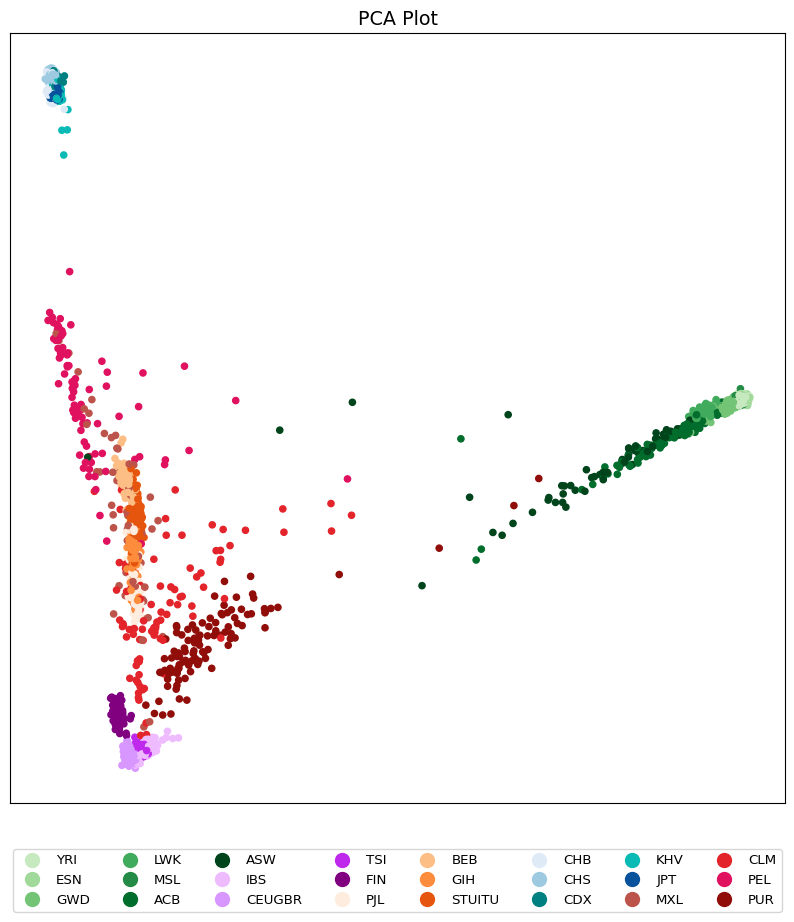

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(pca_input_1K[:, [0, 1]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

In [10]:
# Project MHI onto 1000G
pca_input_mhi = pca_1K.transform(inputs_mhi)

/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/scprep/plot/scatter.py:438: UserWarning: Cannot create a legend with constant `c=black`
  warnings.warn(


<Axes: title={'center': 'PCA Plot'}>

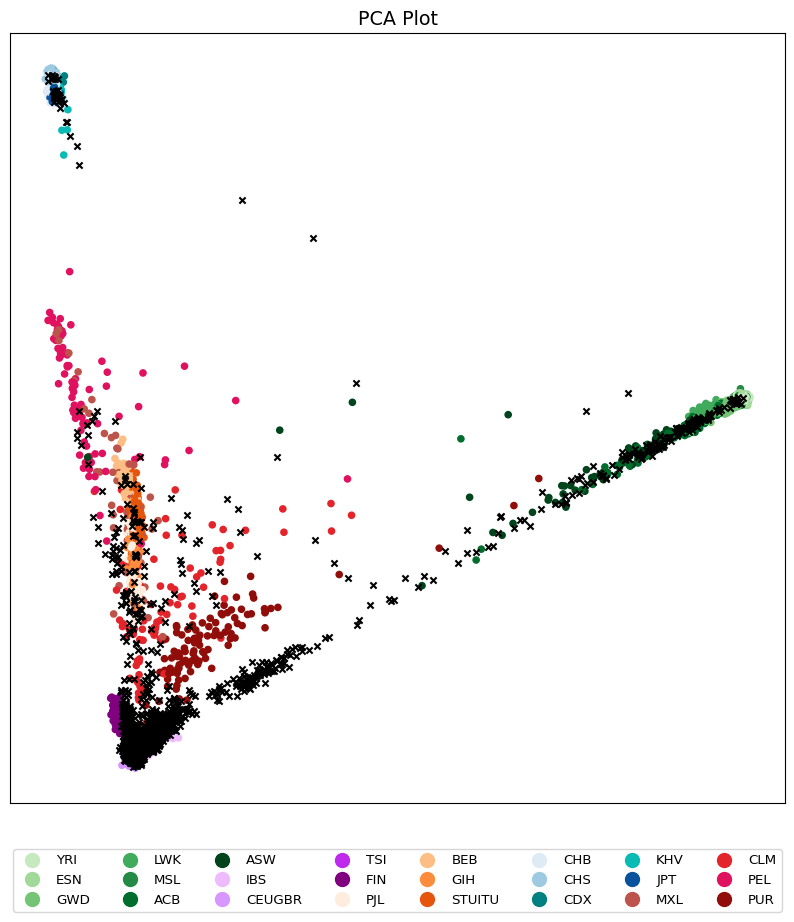

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(pca_input_1K[:, [0, 1]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

scprep.plot.scatter2d(pca_input_mhi[:, [0, 1]], c='black', marker='x', s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

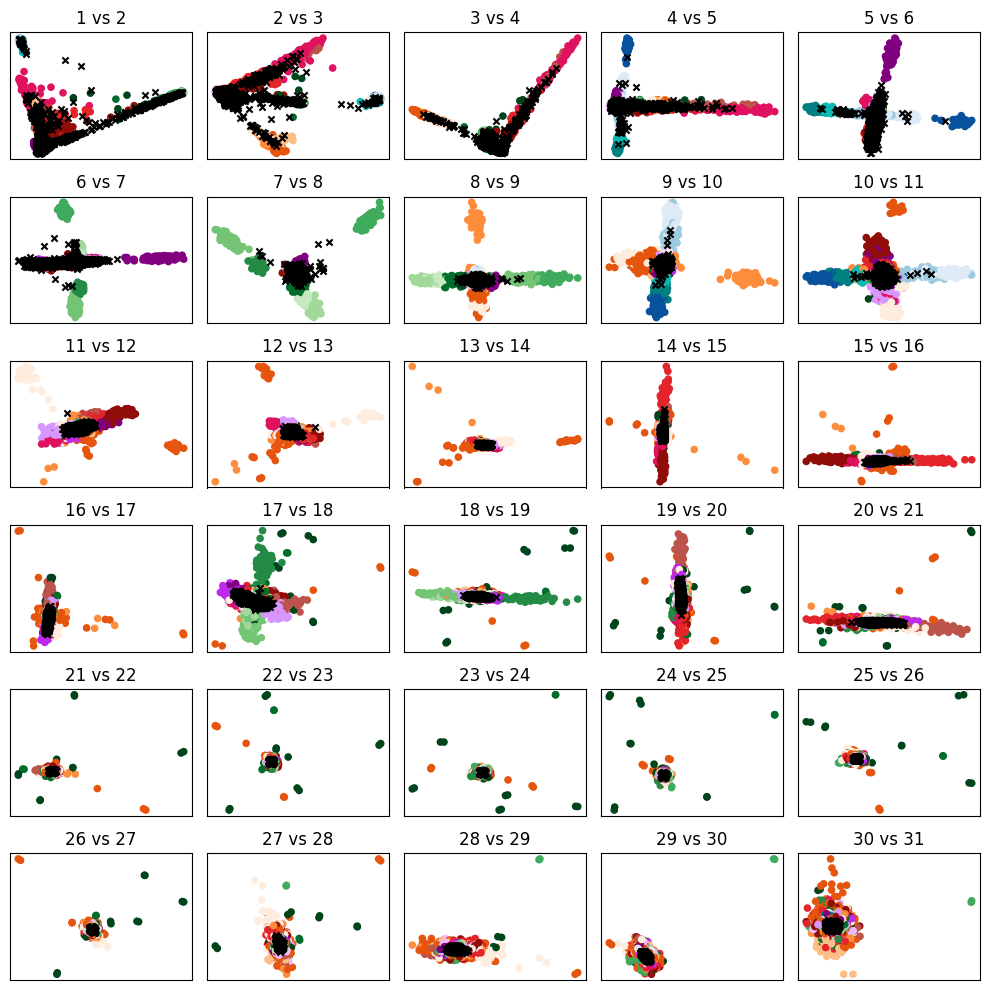

In [12]:
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(10, 10))

comp = 1
for i in range(6):
    for j in range(5):
        scprep.plot.scatter2d(pca_input_1K[:, [comp-1, comp]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax[i,j],
                              c = labels_1K['population'], xticks=False, yticks=False,
                              legend=False, title='PCA Plot',fontsize=8)
        scprep.plot.scatter2d(pca_input_mhi[:, [comp-1, comp]], s = 20, c='black', marker='x', ax=ax[i,j],
                              xticks=False, yticks=False,
                              legend=False, title='PCA Plot')

        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].set_title('{} vs {}'.format(comp, comp+1), fontsize=12)

        comp += 1

plt.tight_layout()


## Do Embedding

First just do PHATE on 1000G

In [13]:
phate_operator = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator.fit(pca_input_1K)
phate_emb_1K = phate_operator.transform(pca_input_1K)

Running PHATE on 2504 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.38 seconds.
  Calculating affinities...
  Calculated affinities in 0.07 seconds.
Calculated graph and diffusion operator in 0.46 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.16 seconds.
  Calculating KMeans...
  Calculated KMeans in 4.97 seconds.
Calculated landmark operator in 5.71 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.71 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.03 seconds.


<Axes: title={'center': 'PCA Plot'}>

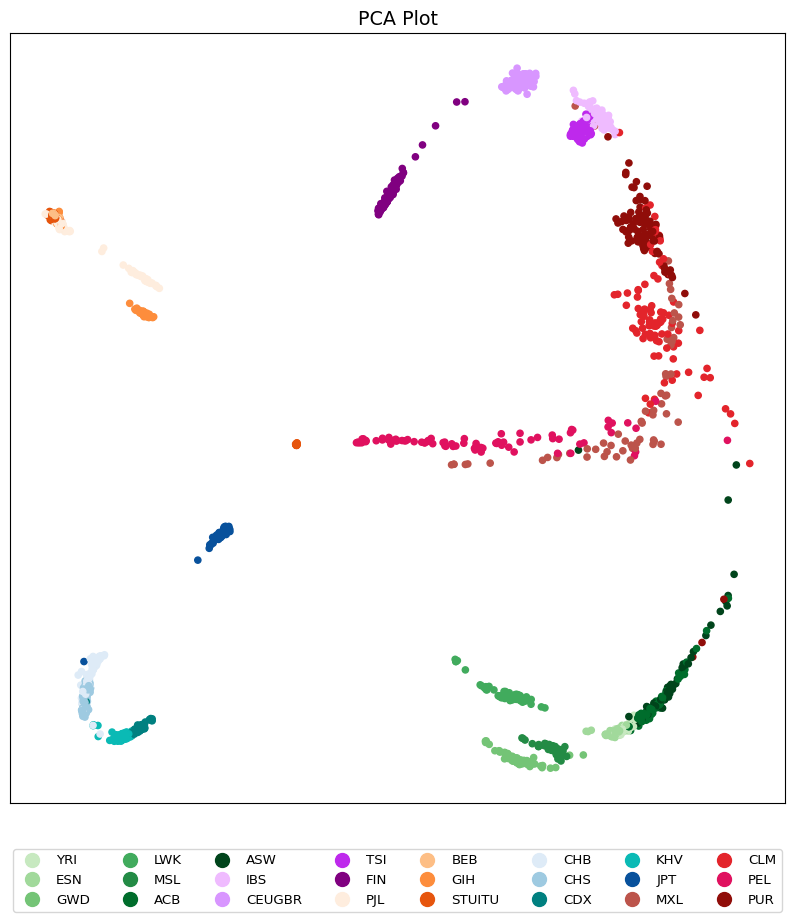

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(phate_emb_1K, s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

Now embed 2D MHI onto this

In [15]:
phate_emb_mhi = phate_operator.transform(pca_input_mhi)

Calculating KNN search...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 2.37 seconds.
Calculating affinities...
Calculated affinities in 0.26 seconds.


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/scprep/plot/scatter.py:438: UserWarning: Cannot create a legend with constant `c=black`
  warnings.warn(


<Axes: title={'center': 'PHATE Plot'}>

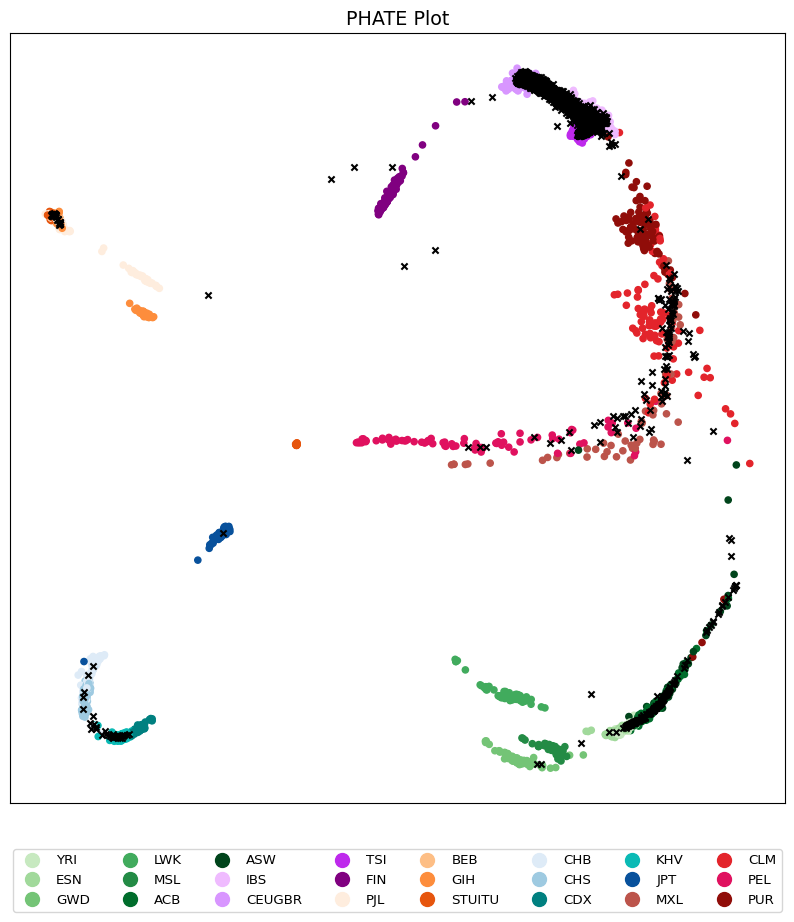

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(phate_emb_1K, s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',fontsize=8)

scprep.plot.scatter2d(phate_emb_mhi, c='black', marker='x', s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',fontsize=8)

<Axes: title={'center': 'PHATE Plot'}>

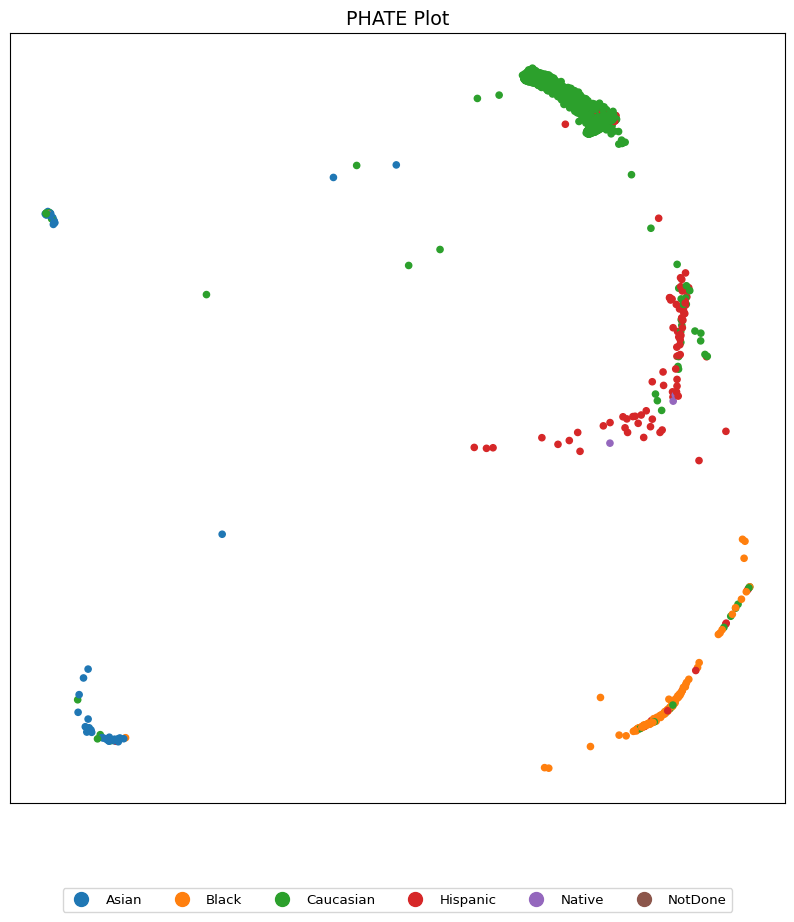

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(phate_emb_mhi, c = metadata_mhi, cmap=pop_pallette_mhi, s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PHATE Plot',fontsize=8)

## Try to get 10D PHATE

In [18]:
phate_operator.set_params(n_components=10, verbose=3)
phate_emb_1K_10d = phate_operator.transform(pca_input_1K)
phate_emb_mhi_10d = phate_operator.transform(pca_input_mhi)

Set graphtools logging to DEBUG
Calculating metric MDS...
  Performing classic MDS on ndarray of shape (1750, 1750)...
  Performing non-metric MDS on <class 'numpy.ndarray'> of shape (1750, 1750)...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Calculated metric MDS in 109.08 seconds.
Extending to original data...
Calculating KNN search...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 2.36 seconds.
Calculating affinities...
  search_knn = 30; 978 remaining
  radius search on 978
Calculated affinities in 0.26 seconds.


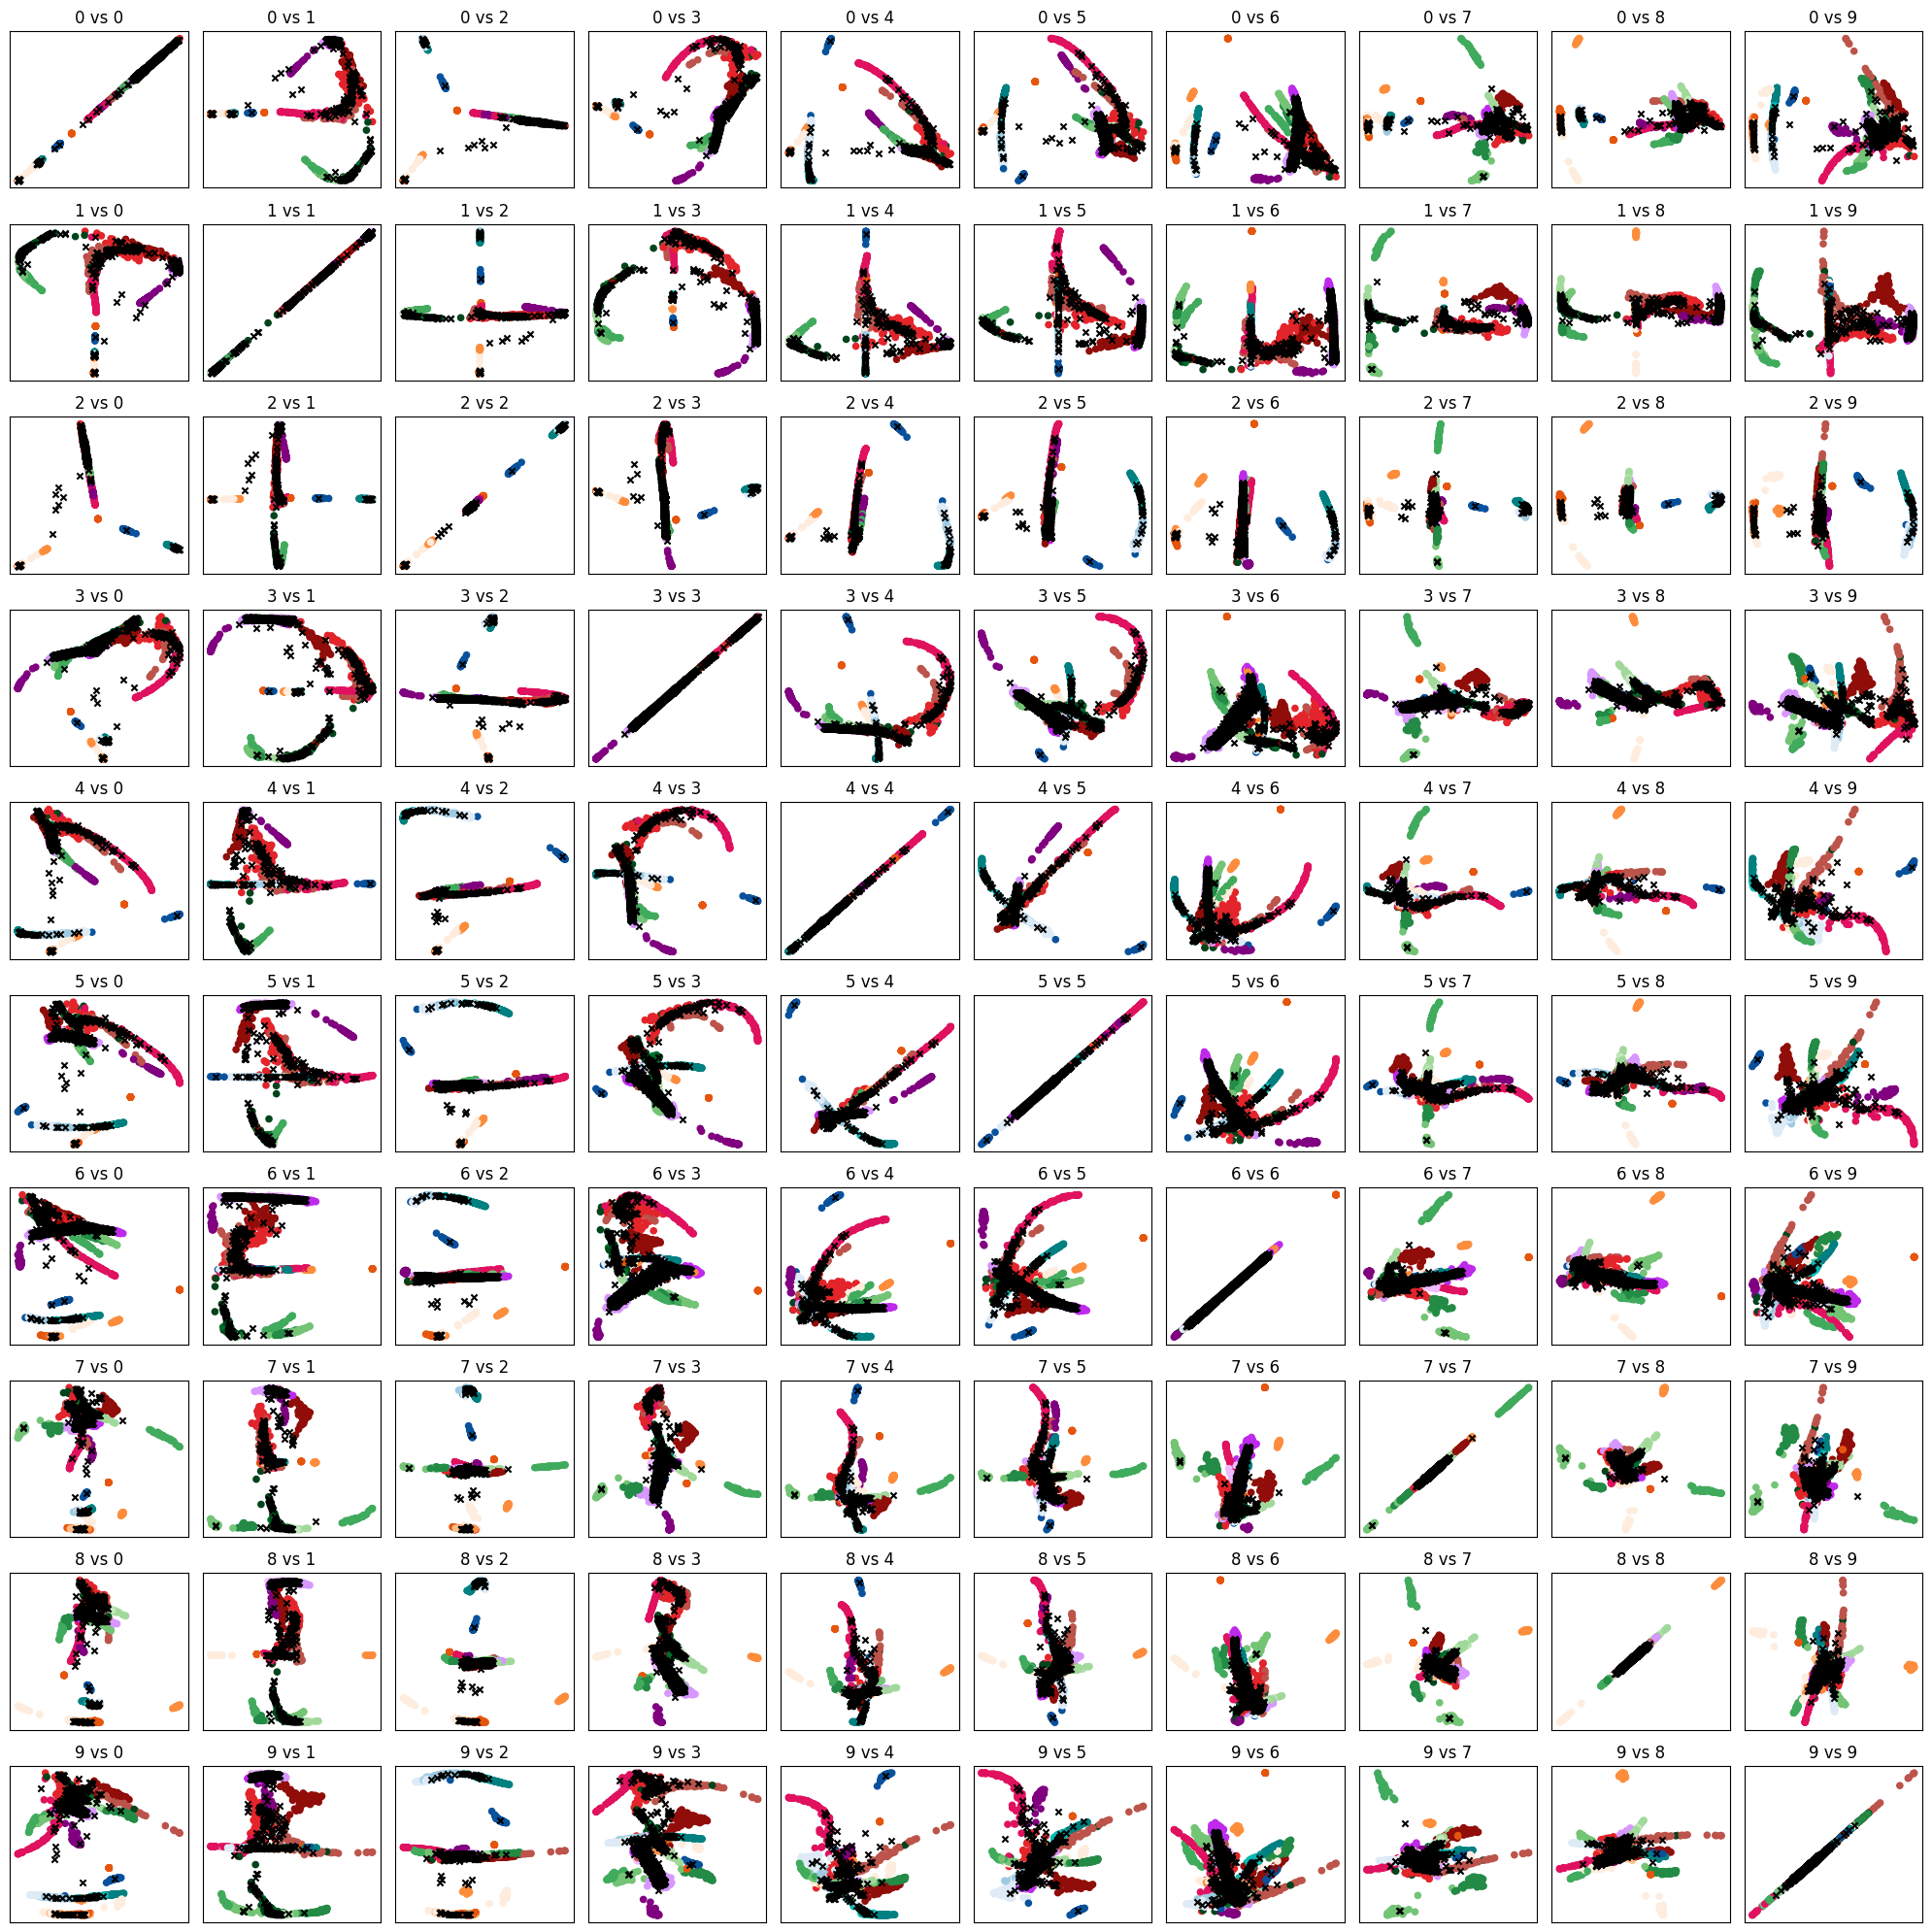

In [21]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        scprep.plot.scatter2d(phate_emb_1K_10d[:,[i, j]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax[i,j],
                              c = labels_1K['population'], xticks=False, yticks=False,
                              legend=False, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                              title='PHATE Plot',fontsize=8)

        scprep.plot.scatter2d(phate_emb_mhi_10d[:,[i, j]], c='black', marker='x', s = 20, ax=ax[i,j], xticks=False, yticks=False,
                              legend=False, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                              title='PHATE Plot',fontsize=8)

        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].set_title('{} vs {}'.format(i, j), fontsize=12)

plt.tight_layout()

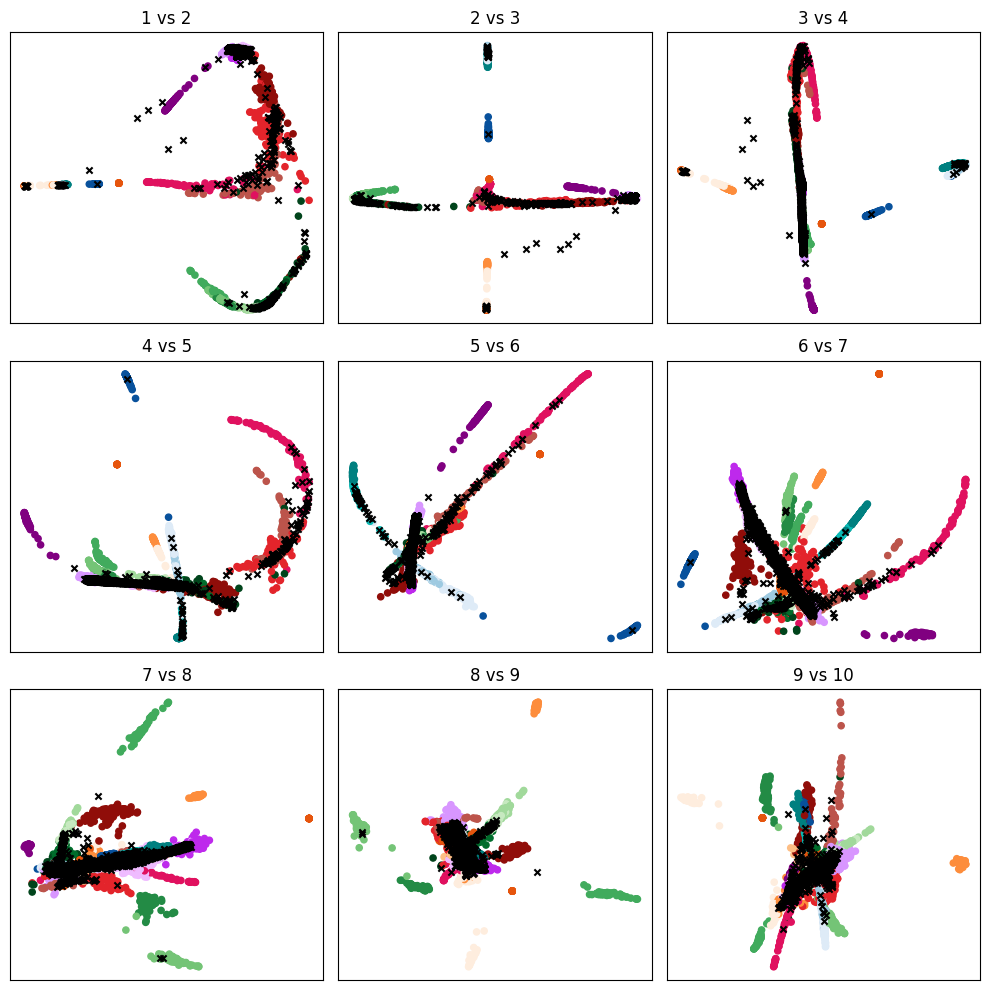

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

comp = 1
for i in range(3):
    for j in range(3):
        scprep.plot.scatter2d(phate_emb_1K_10d[:, [comp-1, comp]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax[i,j],
                              c = labels_1K['population'], xticks=False, yticks=False,
                              legend=False, title='PCA Plot',fontsize=8)
        scprep.plot.scatter2d(phate_emb_mhi_10d[:, [comp-1, comp]], s = 20, c='black', marker='x', ax=ax[i,j],
                              xticks=False, yticks=False,
                              legend=False, title='PCA Plot')

        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].set_title('{} vs {}'.format(comp, comp+1), fontsize=12)

        comp += 1

plt.tight_layout()


In [26]:
pd.DataFrame(phate_emb_mhi_10d, index=samples_mhi).to_csv('/lustre06/project/6065672/shared/trajGWAS/mhi_10d_phate.csv')
pd.DataFrame(pca_input_mhi, index=samples_mhi).to_csv('/lustre06/project/6065672/shared/trajGWAS/mhi_100d_pca.csv')

## Maybe Eigendecompose Diffusion Operator Instead?

In [64]:
transitions_1K = phate_operator.graph.extend_to_data(pca_input_1K)
transitions_mhi = phate_operator.graph.extend_to_data(pca_input_mhi)

Calculating KNN search...
Calculated KNN search in 0.36 seconds.
Calculating affinities...
  search_knn = 30; 133 remaining
  radius search on 133
Calculated affinities in 0.06 seconds.
Calculating KNN search...
Calculated KNN search in 2.36 seconds.
Calculating affinities...
  search_knn = 30; 978 remaining
  radius search on 978
Calculated affinities in 0.26 seconds.


In [67]:
# Fit PCA model
pca_1K_diff_op = PCA(n_components=100)  # Number of components to keep
pca_1K_diff_op.fit(transitions_1K.toarray())
pca_diff_op_1K = pca_1K_diff_op.transform(transitions_1K.toarray())
pca_diff_op_mhi = pca_1K_diff_op.transform(transitions_mhi.toarray())

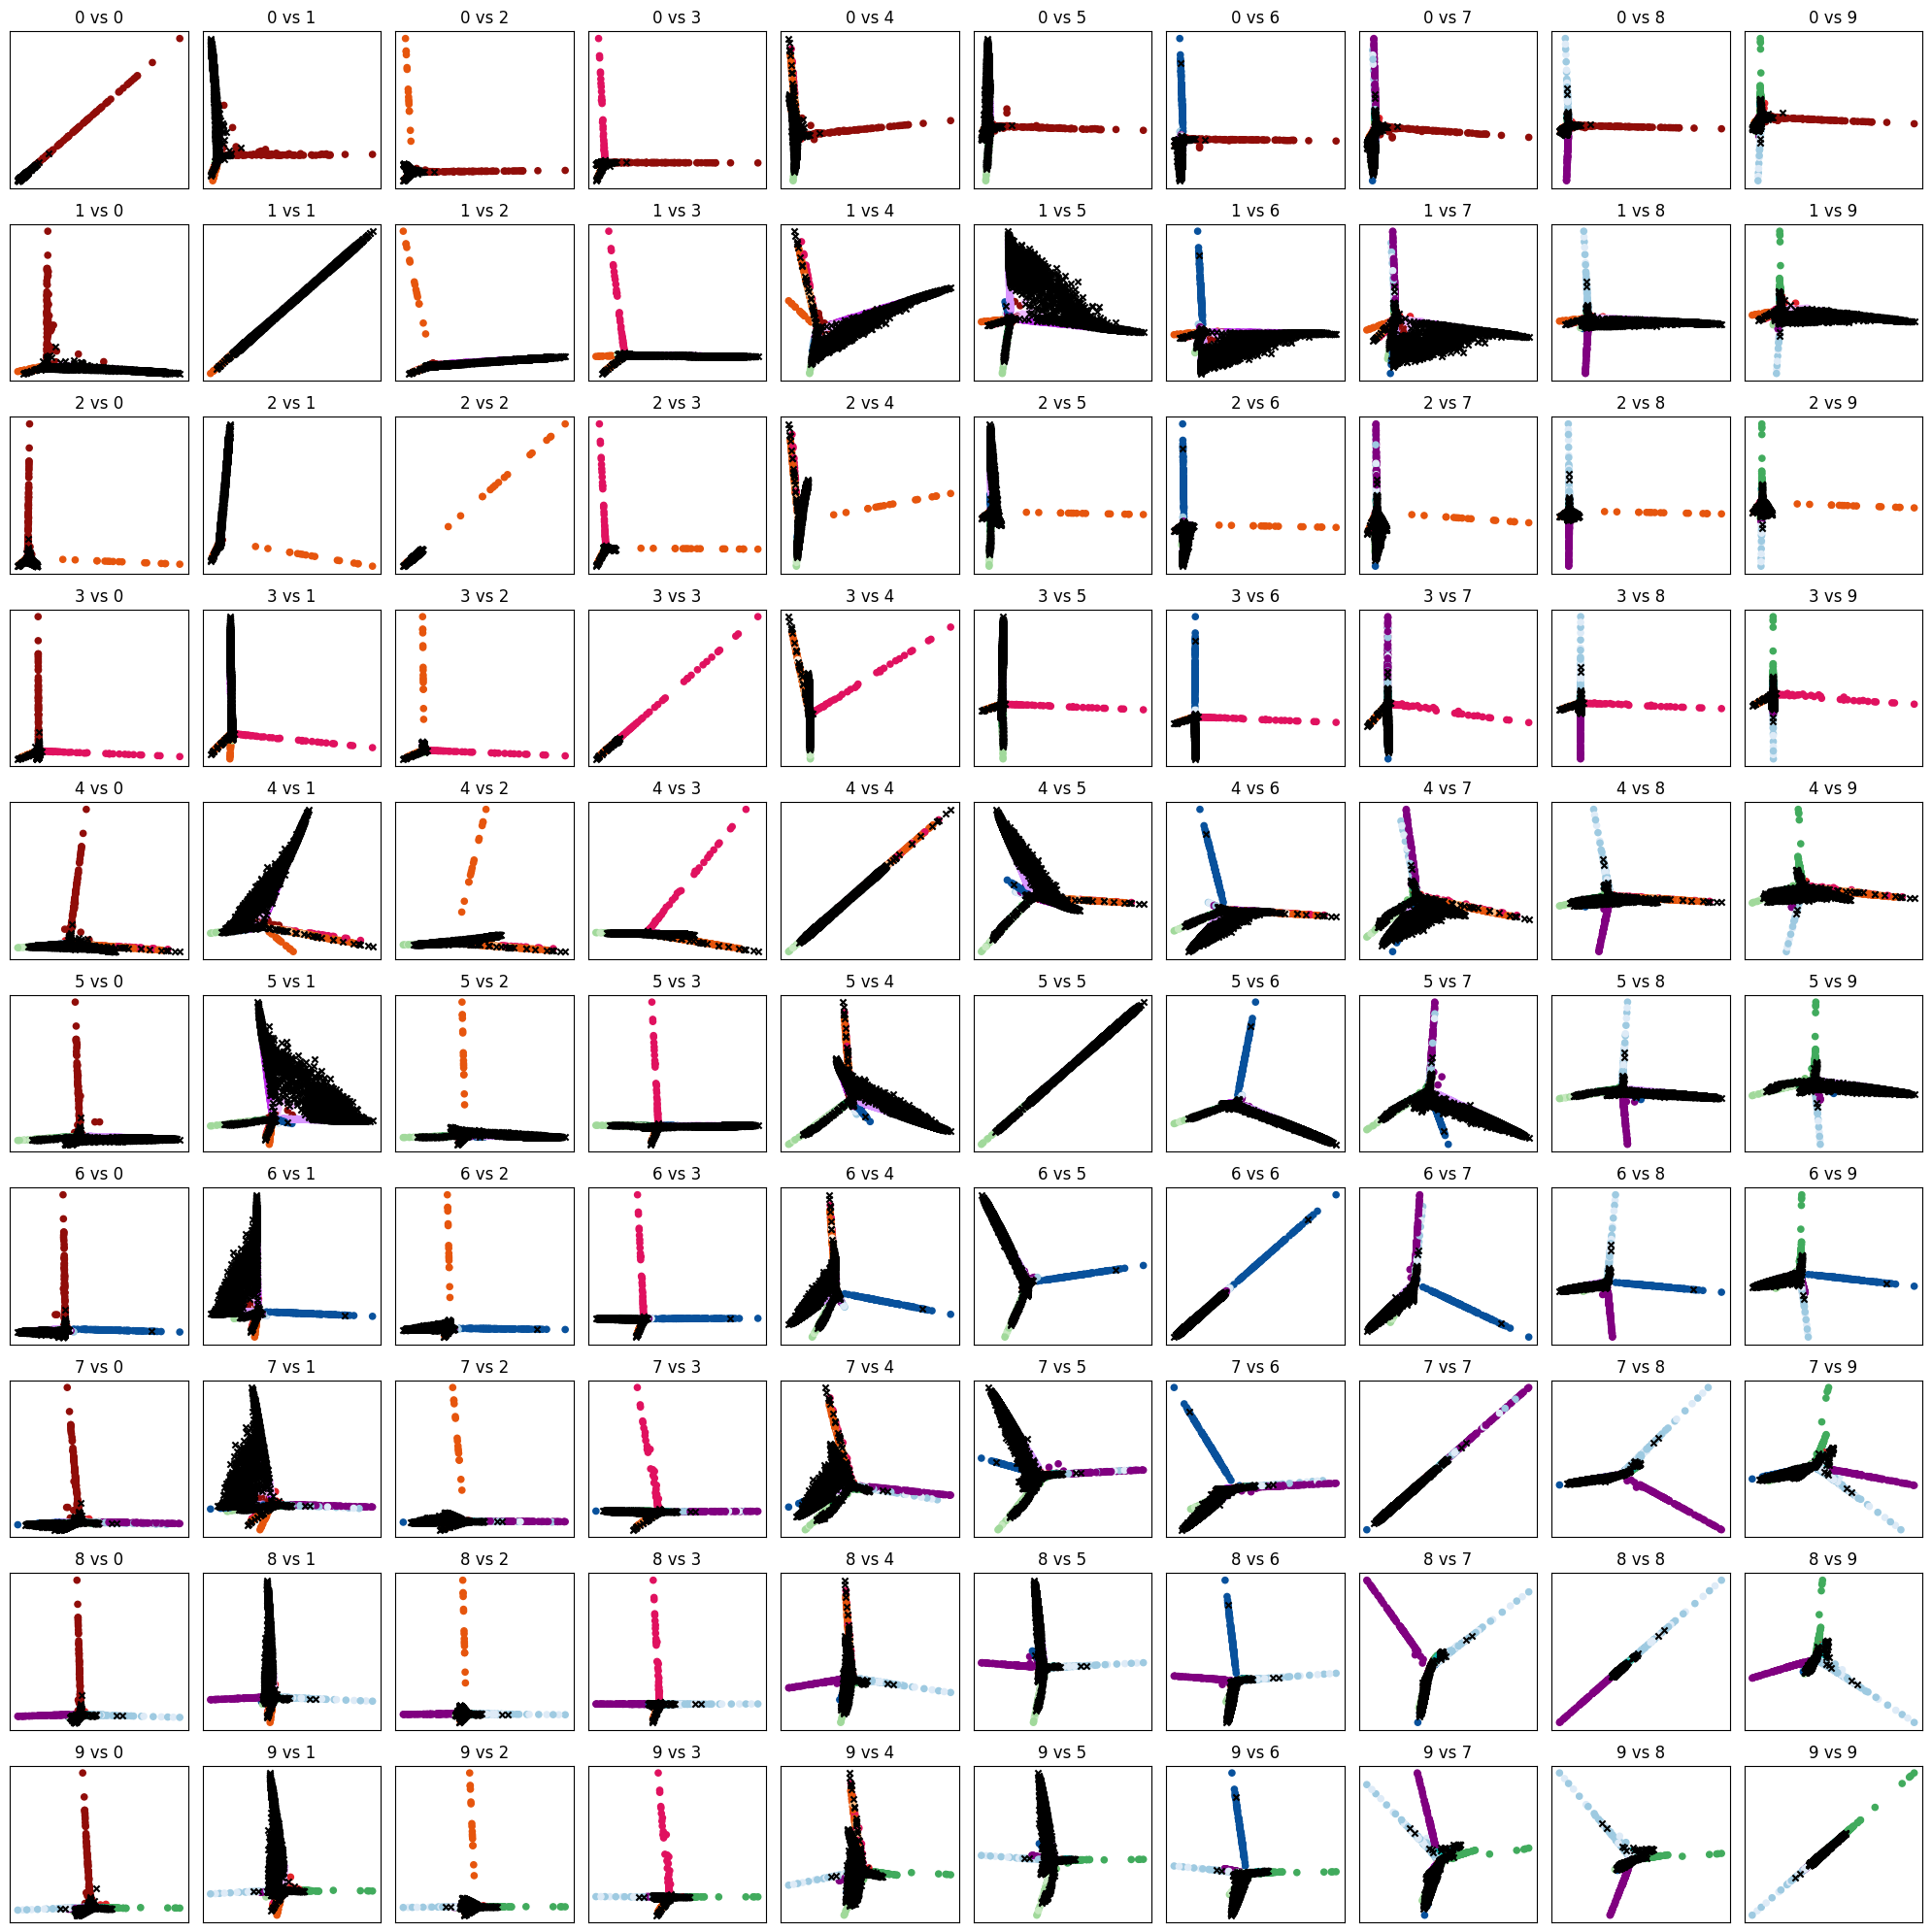

In [68]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        scprep.plot.scatter2d(pca_diff_op_1K[:,[i, j]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax[i,j],
                              c = labels_1K['population'], xticks=False, yticks=False,
                              legend=False, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                              title='PHATE Plot',fontsize=8)

        scprep.plot.scatter2d(pca_diff_op_mhi[:,[i, j]], c='black', marker='x', s = 20, ax=ax[i,j], xticks=False, yticks=False,
                              legend=False, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                              title='PHATE Plot',fontsize=8)

        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].set_title('{} vs {}'.format(i, j), fontsize=12)

plt.tight_layout()

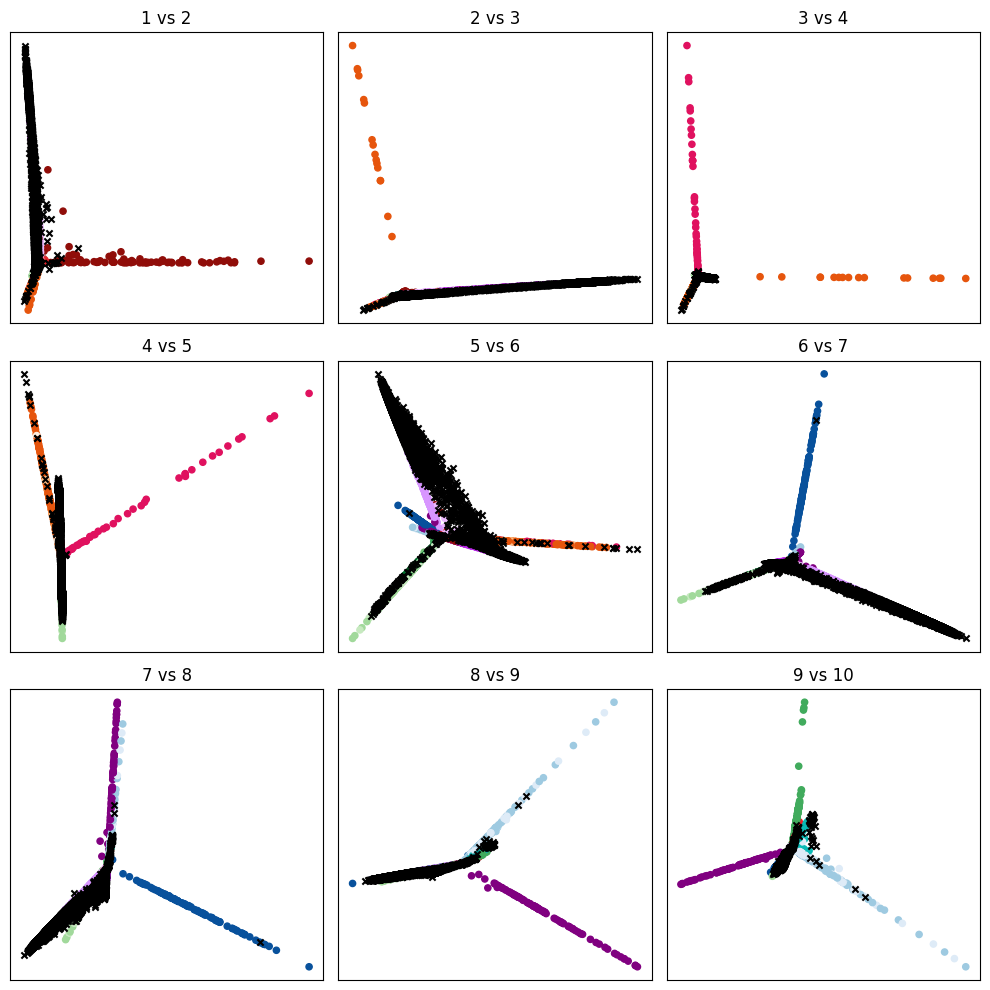

In [70]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

comp = 1
for i in range(3):
    for j in range(3):
        scprep.plot.scatter2d(pca_diff_op_1K[:, [comp-1, comp]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax[i,j],
                              c = labels_1K['population'], xticks=False, yticks=False,
                              legend=False, title='PCA Plot',fontsize=8)
        scprep.plot.scatter2d(pca_diff_op_mhi[:, [comp-1, comp]], s = 20, c='black', marker='x', ax=ax[i,j],
                              xticks=False, yticks=False,
                              legend=False, title='PCA Plot')

        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].set_title('{} vs {}'.format(comp, comp+1), fontsize=12)

        comp += 1

plt.tight_layout()

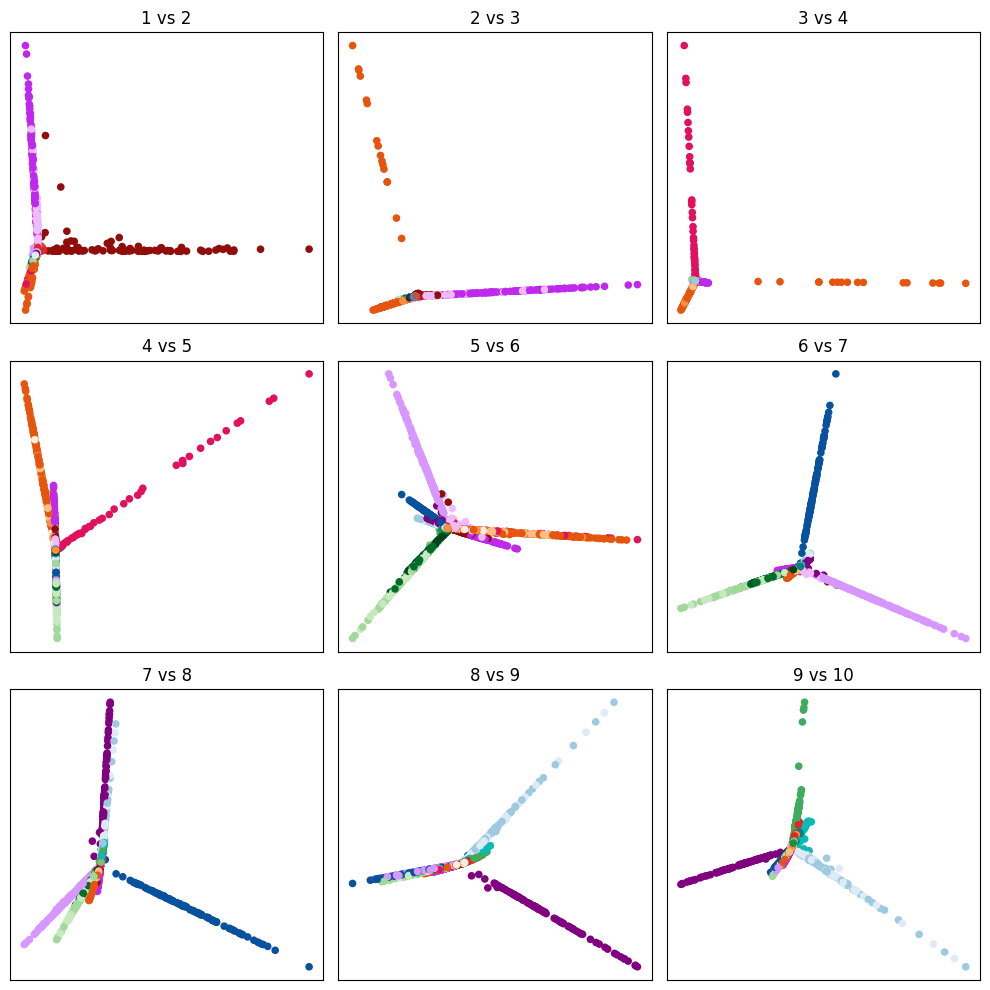

In [71]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

comp = 1
for i in range(3):
    for j in range(3):
        scprep.plot.scatter2d(pca_diff_op_1K[:, [comp-1, comp]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax[i,j],
                              c = labels_1K['population'], xticks=False, yticks=False,
                              legend=False, title='PCA Plot',fontsize=8)

        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].set_title('{} vs {}'.format(comp, comp+1), fontsize=12)

        comp += 1

plt.tight_layout()

In [69]:
pd.DataFrame(pca_diff_op_mhi, index=samples_mhi).to_csv('/lustre06/project/6065672/shared/trajGWAS/mhi_pcs_of_diff_op.csv')

## Scree Plots

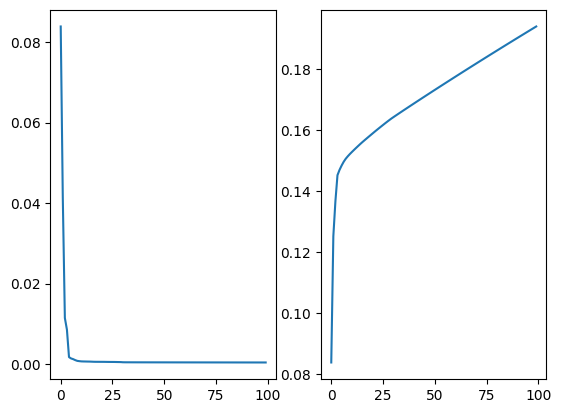

In [82]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(pca_1K.explained_variance_ratio_)
ax[1].plot(pca_1K.explained_variance_ratio_.cumsum())

In [138]:
# top 10 PCs explains 15.3% of the variance
pca_1K.explained_variance_ratio_.cumsum()[10]

0.1529489545501985

In [139]:
# top 100 PCs explains 19.4% of the variance. So this is upper limit of PHATE
pca_1K.explained_variance_ratio_.cumsum()[-1]

0.19408999305179608

## Estimate how much PHATE Captures the 100D PCA

In [163]:
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

In [158]:
pca_dists = pdist(pca_input_1K)
pca_dists_10d = pdist(pca_input_1K[:,:10])
phate_dists = pdist(phate_emb_1K_10d)

In [165]:
r_subset = np.random.choice(len(phate_dists), 10000, replace=False)
print(spearmanr(pca_dists[r_subset], pca_dists[r_subset]))
print(spearmanr(pca_dists[r_subset], pca_dists_10d[r_subset]))
print(spearmanr(pca_dists[r_subset], phate_dists[r_subset]))

SignificanceResult(statistic=1.0, pvalue=0.0)
SignificanceResult(statistic=0.959649403100494, pvalue=0.0)
SignificanceResult(statistic=0.5271713291917133, pvalue=0.0)


## Mutual Information Estimation (Work in Progress)

In [140]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mutual_info_score

def calculate_entropy(x):
    """ Calculate the entropy of a discrete variable. """
    _, counts = np.unique(x, return_counts=True)
    probabilities = counts / len(x)
    entropy = -np.sum(probabilities * np.log(probabilities))
    return entropy

def normalized_mutual_info(x, y):
    """ Calculate normalized mutual information between two discrete variables. """
    mi = mutual_info_score(x, y)
    hx = calculate_entropy(x)
    hy = calculate_entropy(y)
    return mi / np.sqrt(hx * hy)

def compute_mi(original_data, embedded_data, n_bins=10):
    # Discretize the original 100D data and top 10 PCs
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform', subsample=None)
    discretized_original_data = discretizer.fit_transform(original_data)
    discretized_embedded_data = discretizer.fit_transform(embedded_data)

    # Calculate mutual information between each of the top 10 PCs and the original data
    mi_scores = []
    for i in range(embedded_data.shape[1]):
        mi_score = 0
        for j in range(original_data.shape[1]):
            mi_score += normalized_mutual_info(discretized_embedded_data[:, i], discretized_original_data[:, j])
        mi_scores.append(mi_score / original_data.shape[1])  # Normalize by the number of original dimensions

    # Average mutual information
    avg_mi = np.mean(mi_scores)

    print(f"Average Normalized Mutual Information between original data and embedded data with {n_bins} bins: {avg_mi}")

In [141]:
# Example data
np.random.seed(0)
original_data = np.random.rand(100, 100)  # 100 samples, 100 features

# Perform PCA to get top 10 PCs
pca = PCA(n_components=10)
embedded_data = pca.fit_transform(original_data)

# Compute mutual information with different bin settings
for bins in [10, 20, 30, 40, 50]:
    print(f"Using {bins} bins:")
    compute_mi(original_data, embedded_data, n_bins=bins)
    compute_mi(original_data, original_data, n_bins=bins)
    random_embedded_data = np.random.rand(100, 10)
    compute_mi(original_data, random_embedded_data, n_bins=bins)

Using 10 bins:
Average Normalized Mutual Information between original data and embedded data with 10 bins: 0.19962509070288376
Average Normalized Mutual Information between original data and embedded data with 10 bins: 0.2193312178310063
Average Normalized Mutual Information between original data and embedded data with 10 bins: 0.21166182211785153
Using 20 bins:
Average Normalized Mutual Information between original data and embedded data with 20 bins: 0.43298629029830293
Average Normalized Mutual Information between original data and embedded data with 20 bins: 0.4707802138332622
Average Normalized Mutual Information between original data and embedded data with 20 bins: 0.4670702741986724
Using 30 bins:
Average Normalized Mutual Information between original data and embedded data with 30 bins: 0.5687546610795792
Average Normalized Mutual Information between original data and embedded data with 30 bins: 0.6060615600610885
Average Normalized Mutual Information between original data and 

In [109]:
compute_mi(pca_input_1K, pca_input_1K)
compute_mi(pca_input_1K, phate_emb_1K_10d)
compute_mi(pca_input_1K, pca_diff_op_1K[:,:10])


Average Normalized Mutual Information between original data and embedded data with 10 bins: 0.027133613497252226
Average Normalized Mutual Information between original data and embedded data with 10 bins: 0.046863272908997236
Average Normalized Mutual Information between original data and embedded data with 10 bins: 0.028709736066578884
